In [1]:
%%bash
pip install pybursts
pip install burst_detection

  Running setup.py bdist_wheel for pybursts: started
  Running setup.py bdist_wheel for pybursts: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/79/ed/c5/db1fc9c9190e98e995442da1470b4fd0cf886110e32f1a4e4e
Successfully built pybursts
  Running setup.py bdist_wheel for burst-detection: started
  Running setup.py bdist_wheel for burst-detection: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/45/29/09/f89eccff45be307548ab1fe832104f0fd33669fa64a1bd4741
  Running setup.py bdist_wheel for sympy: started
  Running setup.py bdist_wheel for sympy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/05/93/22/2d0f59d842347b1f38df0d3f7a3870586df60568d2a49d94c5
  Running setup.py bdist_wheel for mpmath: started
  Running setup.py bdist_wheel for mpmath: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/02/2b/99/cd867d5da48d951118a8020e86c0c12a65022702426582d4b8
Successfully built burst-detection s

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
You are using pip v

In [2]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math
import pylab as pl

import burst_detection as bd
import pybursts
from matplotlib.patches import Rectangle

from opengrid.library import houseprint

from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean/Block_detection at 127.0.0.1:57965


In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [4]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

<h1>Try to detect single peaks and substract them from the original signal</h1>

In [5]:
#Get Electricity data
head = pd.Timestamp('2015-11-15 01:00:00')
tail = pd.Timestamp('2015-11-16 01:00:00')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

Using tmpo database from /data/.tmpo/tmpo.sqlite3


/usr/local/opengrid/opengrid/library/houseprint/sensor.py:280: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index


In [6]:
df_el_diff = df_el.diff()
df_el_diff[abs(df_el_diff) < 50] = 0
result = pd.concat([df_el, df_el_diff], axis=1).dropna()
result.columns = ['cons', 'diff']

In [7]:
charts.plot(result, show="inline", stock=True)

In [8]:
#treshhold to compare consumptionlevel
searching = 'false'

#pending on
index_on = 0

#events list
events = pd.DataFrame(columns=['start', 'stop'])

#Iterate through the differential timeseries
for i in range(0, df_el_diff.size):
    if searching == 'false' and df_el_diff[i] > 0 and df_el_diff[i-1] == 0 and df_el_diff[i-2] == 0:
        #i-1 is the first point before the peak
        index_on = str(df_el_diff.index[i-1])
        
        searching = 'true'
    
    elif searching == 'true' and df_el_diff[i] == 0:
        #No small peak
        searching = 'false'
    elif searching == 'true' and df_el_diff[i] < 0 and df_el_diff[i + 1] == 0 and df_el_diff[i + 2] == 0:
        temp = pd.DataFrame(data=[[index_on, str(df_el_diff.index[i])]], columns=['start', 'stop'])
        events = events.append(temp)
        
        searching = 'false'
        

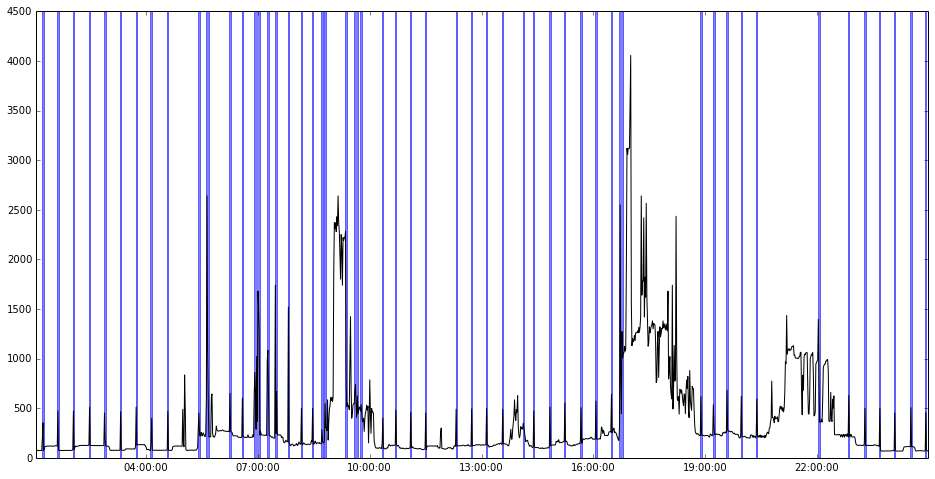

In [9]:
fig, ax = plt.subplots()
ax.plot(df_el.index, df_el, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, events.index.size):
    ax.axvspan(events['start'].iloc[i], events['stop'].iloc[i], alpha=0.5, color=colors[1])

plt.show()

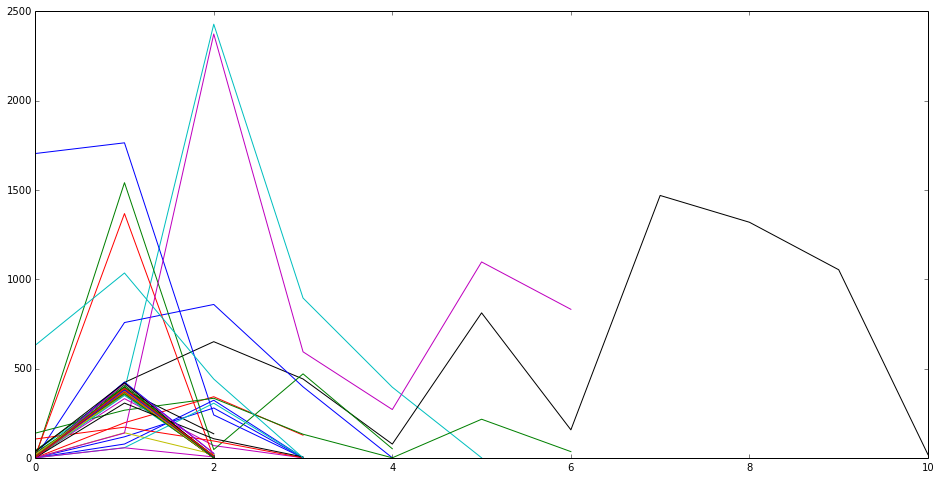

In [10]:
df_el_2 = df_el

#Substract single peaks from total consumption
for i in range(0, events.index.size):
    df_event = df_el.ix[pd.Timestamp(events['start'].iloc[i]):pd.Timestamp(events['stop'].iloc[i])]
    df_event = df_event.sub(df_event.min())
    
    #if df_event[0]/df_event.max() < 0.25 and df_event[df_event.size-1]/df_event.max() < 0.25:
    merge = pd.concat([df_el, df_event], axis=1).fillna(0)
    merge.columns = ['original', 'event']
    df_el = merge['original'].sub(merge['event'], axis=0)
    plt.plot(df_event)
    

In [11]:
df_el_diff2 = df_el.diff()
df_el_diff2[abs(df_el_diff2) < 50] = 0
result = pd.concat([df_el_2, df_el, df_el_diff, df_el_diff2], axis=1).dropna()
result.columns = ['original', 'new', 'diff', 'diff2']
charts.plot(result, show="inline", stock=True)

In [12]:
rm = df_el.rolling(window=10,center=False).median()

In [13]:
rm.index = rm.index - pd.Timedelta(minutes=5)

In [14]:
rm_diff = rm.diff()
rm_diff[abs(rm_diff) < 100] = 0
result = pd.concat([df_el, rm, rm_diff], axis=1).dropna()
result.columns = ['original', 'median', 'rm_diff']
charts.plot(result, show="inline", stock=True)

In [15]:
#treshhold to compare consumptionlevel
searching = 'false'

#pending on
index_on = 0
value_on = 0
pending_on = pd.DataFrame(columns=['index_on', 'value_on'])

#events list
events2 = pd.DataFrame(columns=['start', 'stop'])

#Iterate through the differential timeseries
for i in range(0, rm_diff.size):
    if searching == 'false' and rm_diff[i] > 0 and rm_diff[i-1] == 0 and rm_diff[i-2] == 0:
        #i-1 is the first point before the peak
        index_on = str(rm_diff.index[i-1])
        value_on = rm[rm_diff.index[i-1]]
        
        searching = 'true'
        
    elif searching == 'true' and rm_diff[i] > 0 and rm_diff[i-1] == 0 and rm_diff[i-2] == 0:
        temp = pd.DataFrame(data=[[str(rm_diff.index[i-1]), rm[rm_diff.index[i-1]]]], columns=['index_on', 'value_on'])
        pending_on = pending_on.append(temp)
        
    elif searching == 'true' and rm_diff[i] < 0 and rm_diff[i + 1] == 0 and rm_diff[i + 2] == 0:
        
        # get max between on-off
        max_value = rm.ix[pd.Timestamp(index_on):rm_diff.index[i + 1]].max()
        
        if (abs(rm[rm_diff.index[i]] - value_on)/(max_value - value_on)) < 0.33:
            temp = pd.DataFrame(data=[[index_on, str(rm_diff.index[i + 3])]], columns=['start', 'stop'])
            events2 = events2.append(temp)
        
            searching = 'false'
            #clear pending on
            pending_on = pending_on[pending_on['index_on'] != '0']
        
        else:
            for j in range(0, pending_on.size):
                # get max between on-off
                max_value = rm.ix[pd.Timestamp(pending_on['index_on'][j]):rm_diff.index[i + 1]].max()

                if (abs(rm[rm_diff.index[i]] - pending_on['value_on'][j])/(max_value - pending_on['value_on'][j])) < 0.33:
                    temp = pd.DataFrame(data=[[pending_on['index_on'][j], str(rm_diff.index[i + 3])]], columns=['start', 'stop'])
                    events2 = events2.append(temp)

                    pending_on = pending_on[pending_on.index != 0]
                    searching = 'false'
                    
                    break
        
        

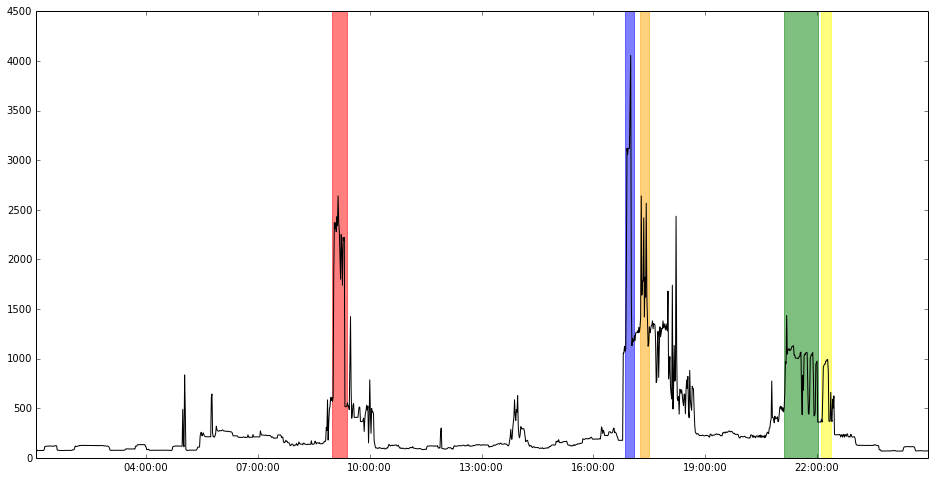

In [16]:
fig, ax = plt.subplots()
ax.plot(df_el.index, df_el, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, events2.index.size):
    ax.axvspan(events2['start'].iloc[i], events2['stop'].iloc[i], alpha=0.5, color=colors[i])

plt.show()

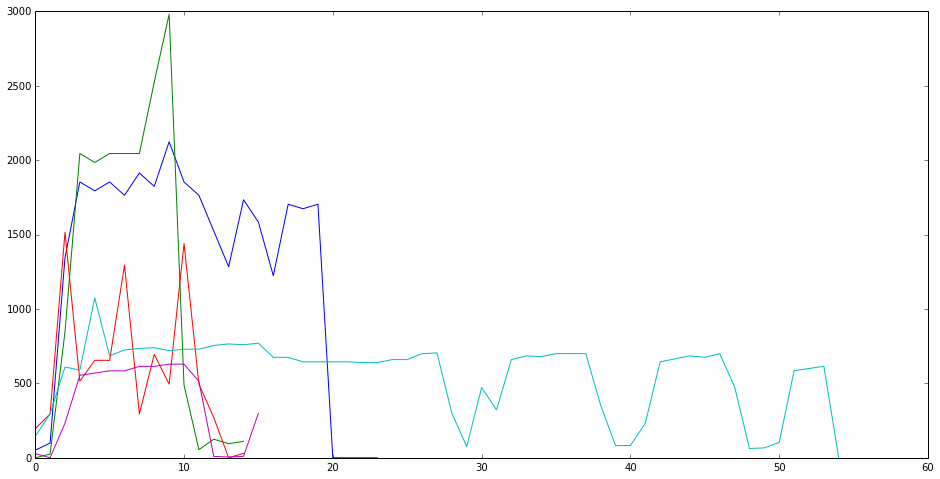

In [17]:
df_el_3 = df_el

#Substract single peaks from total consumption
for i in range(0, events2.index.size):
    df_event = df_el.ix[pd.Timestamp(events2['start'].iloc[i]):pd.Timestamp(events2['stop'].iloc[i])]
    df_event = df_event.sub(df_event.min())
    
    #if df_event[0]/df_event.max() < 0.25 and df_event[df_event.size-1]/df_event.max() < 0.25:
    merge = pd.concat([df_el, df_event], axis=1).fillna(0)
    merge.columns = ['original', 'event']
    df_el = merge['original'].sub(merge['event'], axis=0)
    plt.plot(df_event)
    

In [18]:
result = pd.concat([df_el, df_el_3], axis=1).dropna()
result.columns = ['original', 'median']
charts.plot(result, show="inline", stock=True)

<h1> Burst Detection</h1>

<p>Burst detection doesn't seem to work that well for our applications</p>

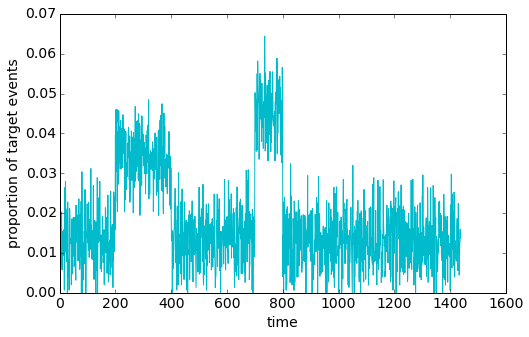

In [19]:
#simulate the baseline data
timepoints = len(df_el)
d = pd.Series(np.floor(np.ones(timepoints)*1500 + np.random.normal(scale=40, size=timepoints))) #total events
r = pd.Series(np.floor(np.ones(timepoints)*20 + np.random.normal(scale=10, size=timepoints)))   #target events
r[r<0] = 0 #set negative values to 0

#add some bursts
r[200:400] = r[200:400] + 30 #+ np.random.normal(scale=10, size=200)
r[700:800] = r[700:800] + 50 #+ np.random.normal(scale=10, size=100)

org_r = r

plt.subplots(figsize=(8, 5))
plt.plot(org_r/d, color='#00bbcc', linewidth=1)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("raw_timeseries.jpg", bbox_inches="tight", dpi=600)

In [20]:
#create a timeline of the bursts
def plot_burst_timeline(bursts, timepoints, label):
    
    f, ax = plt.subplots(figsize=(8, 0.5))
    ax.set(xlim=(0, timepoints), ylabel="", xlabel="")

    #create boxes around bursting periods
    for index, burst in bursts.iterrows():

        #define outline positions
        y = 0.25
        xstart = burst['begin'] -1 
        width = burst['end'] - burst['begin'] +1

        #draw rectangle
        ax.add_patch(Rectangle((xstart,y), width, height=0.5, facecolor='#00bbcc', edgecolor='none', linewidth=1, alpha=0.1))

    #remove borders
    ax.xaxis.set_visible(False)
    plt.yticks([0.5], [label], size=14)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    #add a timeline
    plt.axhline(0.5, linewidth=1, color='k', alpha=1, zorder=0.5)

    plt.show()

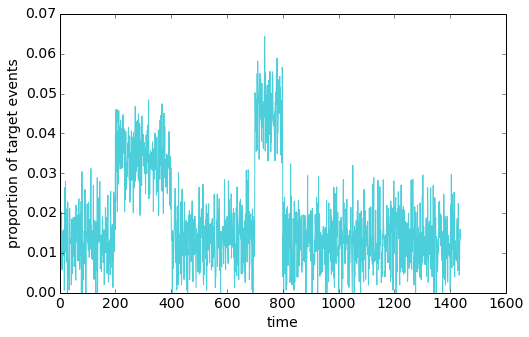

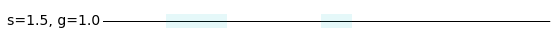

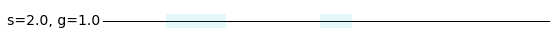

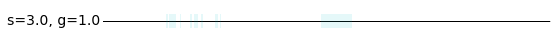

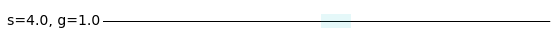

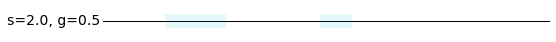

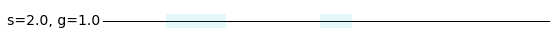

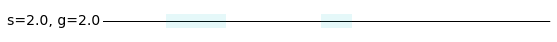

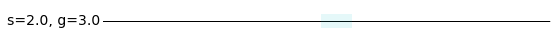

In [21]:
#find bursts

#define variables
n = len(r)    #number of timepoints
k = 2         #number of states

#col 0: s -- resolution of state jumps; higher s --> bigger jumps between states
#col 1: gamma -- difficulty of moving up a state; larger gamma --> harder to move up states
variables = [[1.5, 1.0],
             [2.0, 1.0],
             [3.0, 1.0],
             [4.0, 1.0],
             [2.0, 0.5],
             [2.0, 1.0],
             [2.0, 2.0],
             [2.0, 3.0]]

plt.subplots(figsize=(8, 5))
plt.plot(org_r/d, color='#00bbcc', linewidth=1, alpha=0.7)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("raw_timeseries.jpg", bbox_inches="tight", dpi=600)
plt.show()

for v in variables:

    #find the optimal state sequence (using the Viterbi algorithm)
    [q, _, _, p] = bd.burst_detection(r,d,n,v[0],v[1],smooth_win=5)

    #create label
    label = 's='+str(v[0])+', g='+str(v[1])

    #enumerate the bursts
    bursts = bd.enumerate_bursts(q, label)

    #find weight of each burst
    bursts = bd.burst_weights(bursts, r, d, p)
    
    #plot the optimal state sequence
    plot_burst_timeline(bursts, timepoints, label)

In [22]:
bursts

,label,begin,end,weight
0,"s=2.0, g=3.0",702,801,2032.08


In [23]:
def detect_burst(offsets, s=2, gamma=1):

	if s <= 1:
		raise ValueError("s must be greater than 1!")
	if gamma <= 0:
		raise ValueError("gamma must be positive!")
	if len(offsets) < 1:
		raise ValueError("offsets must be non-empty!")

	offsets = np.array(offsets, dtype=object)
	
	if offsets.size == 1:
		bursts = np.array([0, offsets[0], offsets[0]], ndmin=2, dtype=object)
		return bursts

	offsets = np.sort(offsets)
	gaps = np.diff(offsets)

	if not np.all(gaps):
		gaps[gaps == 0] = 0.000001
		#raise ValueError("Input cannot contain events with zero time between!")

	T = np.sum(gaps)
	n = np.size(gaps)
	g_hat = T / n

	k = int(math.ceil(float(1 + math.log(T, s) + math.log(1 / np.amin(gaps), s))))

	gamma_log_n = gamma * math.log(n)

	def tau(i, j):
		if i >= j:
			return 0
		else:
			return (j - i) * gamma_log_n
	
	alpha_function = np.vectorize(lambda x: s ** x / g_hat)
	alpha = alpha_function(np.arange(k))

	def f(j, x):
		return alpha[j] * math.exp(-alpha[j] * x)

	C = np.repeat(float("inf"), k)
	C[0] = 0

	q = np.empty((k, 0))
	for t in range(n):
		C_prime = np.repeat(float("inf"), k)
		q_prime = np.empty((k, t+1))
		q_prime.fill(np.nan)

		for j in range(k):
			cost_function = np.vectorize(lambda x: C[x] + tau(x, j))
			cost = cost_function(np.arange(0, k))

			el = np.argmin(cost)

			if f(j, gaps[t]) > 0:
				C_prime[j] = cost[el] - math.log(f(j, gaps[t]))
			
			if t > 0:
				q_prime[j,:t] = q[el,:]

			q_prime[j, t] = j + 1

		C = C_prime
		q = q_prime

	j = np.argmin(C)
	q = q[j,:]

	prev_q = 0
	
	N = 0
	for t in range(n):
		if q[t] > prev_q:
			N = N + q[t] - prev_q
		prev_q = q[t]

	bursts = np.array([np.repeat(np.nan, N), np.repeat(offsets[0],N),np.repeat(offsets[0], N)], ndmin=2, dtype=object).transpose()

	burst_counter = -1
	prev_q = 0
	stack = np.repeat(np.nan, N)
	stack_counter = -1
	for t in range(n):
		if q[t] > prev_q:
			num_levels_opened = q[t] - prev_q
			for i in range(int(num_levels_opened)):
				burst_counter += 1
				bursts[burst_counter, 0] = prev_q + i
				bursts[burst_counter, 1] = t #offsets[t]
				stack_counter += 1
				stack[stack_counter] = burst_counter
		elif q[t] < prev_q:
			num_levels_closed = prev_q - q[t]
			for i in range(int(num_levels_closed)):
				bursts[stack[stack_counter], 2] = t #offsets[t]
				stack_counter -= 1
		prev_q = q[t] 

	while stack_counter >= 0:
		bursts[stack[stack_counter], 2] = n#offsets[n]
		stack_counter -= 1

	return bursts

In [24]:
bursts = detect_burst(df_el.as_matrix(), s=2, gamma=1)
bursts = pd.DataFrame(data=bursts, columns= ['label', 'begin', 'end'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:98: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:103: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


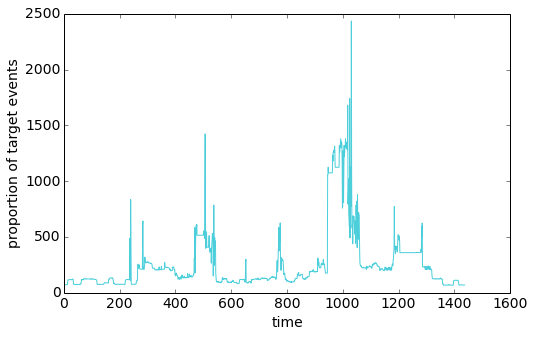

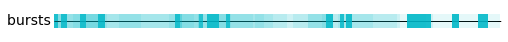

In [25]:
plt.subplots(figsize=(8, 5))
plt.plot(df_el, color='#00bbcc', linewidth=1, alpha=0.7)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("raw_timeseries.jpg", bbox_inches="tight", dpi=600)
plt.show()
plot_burst_timeline(bursts, df_el.size, 'bursts  ')

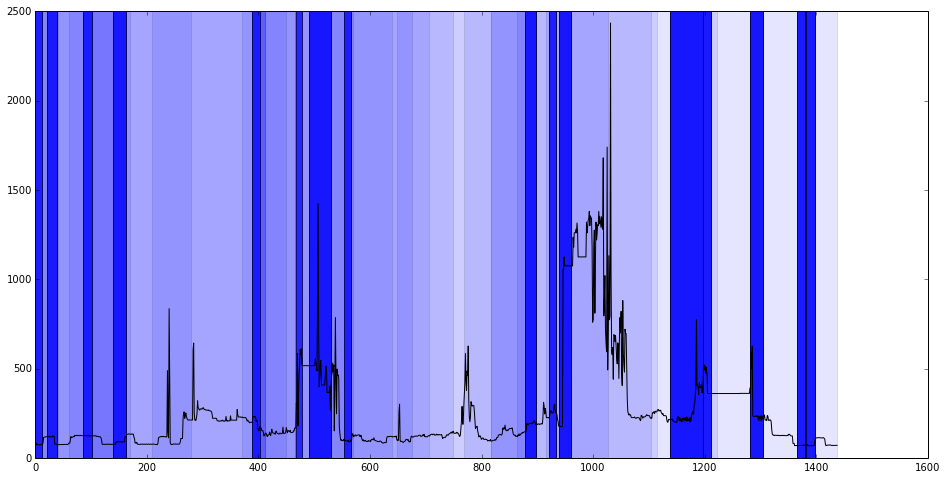

In [26]:
fig, ax = plt.subplots()
ax.plot(df_el, color='black')

#colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, bursts.index.size):
    ax.axvspan(bursts['begin'].iloc[i], bursts['end'].iloc[i], alpha=0.1)

plt.show()

In [27]:
pending_on

,index_on,value_on


In [28]:
pending_on = pending_on[pending_on['index_on'] != '0']

In [29]:
pending_on

,index_on,value_on


<h1>PAA and event detection</h1>

In [30]:
#Get Electricity data
head = pd.Timestamp('2015-11-15 01:00:00')
tail = pd.Timestamp('2015-11-16 01:00:00')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

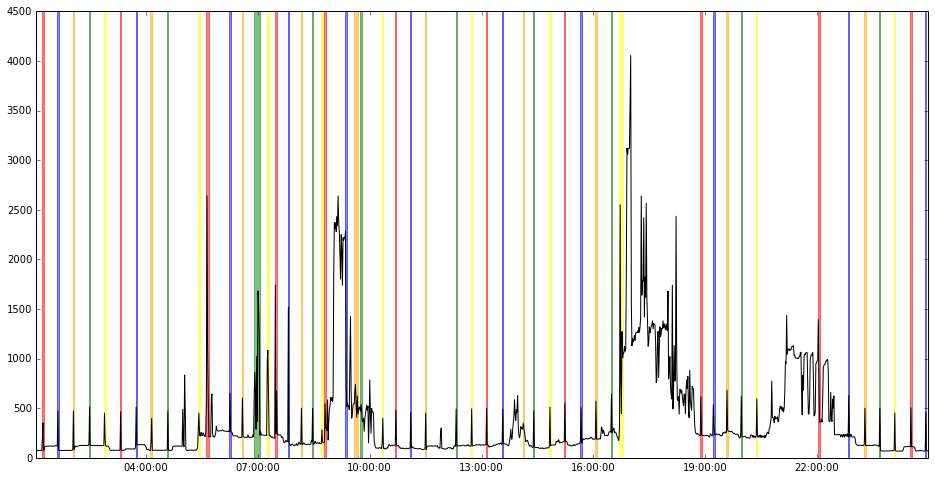

In [31]:
df_el_diff = df_el.diff()
df_el_diff[abs(df_el_diff) < 50] = 0
result = pd.concat([df_el, df_el_diff], axis=1).dropna()
result.columns = ['cons', 'diff']
charts.plot(result, show="inline", stock=True)

#treshhold to compare consumptionlevel
searching = 'false'

#pending on
index_on = 0

#events list
events = pd.DataFrame(columns=['start', 'stop'])

#Iterate through the differential timeseries
for i in range(0, df_el_diff.size):
    if searching == 'false' and df_el_diff[i] > 0 and df_el_diff[i-1] == 0 and df_el_diff[i-2] == 0:
        #i-1 is the first point before the peak
        index_on = str(df_el_diff.index[i-1])
        
        searching = 'true'
    
    elif searching == 'true' and df_el_diff[i] == 0:
        #No small peak
        searching = 'false'
    elif searching == 'true' and df_el_diff[i] < 0 and df_el_diff[i + 1] == 0 and df_el_diff[i + 2] == 0:
        temp = pd.DataFrame(data=[[index_on, str(df_el_diff.index[i])]], columns=['start', 'stop'])
        events = events.append(temp)
        
        searching = 'false'
        
fig, ax = plt.subplots()
ax.plot(df_el.index, df_el, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, events.index.size):
    ax.axvspan(events['start'].iloc[i], events['stop'].iloc[i], alpha=0.5, color=colors[i])

plt.show()
df_el_2 = df_el

#Substract single peaks from total consumption
for i in range(0, events.index.size):
    df_event = df_el.ix[pd.Timestamp(events['start'].iloc[i]):pd.Timestamp(events['stop'].iloc[i])]
    df_event = df_event.sub(df_event.min())
    
    #if df_event[0]/df_event.max() < 0.25 and df_event[df_event.size-1]/df_event.max() < 0.25:
    merge = pd.concat([df_el, df_event], axis=1).fillna(0)
    merge.columns = ['original', 'event']
    df_el = merge['original'].sub(merge['event'], axis=0)
    #plt.plot(df_event)
    

In [32]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [33]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [34]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

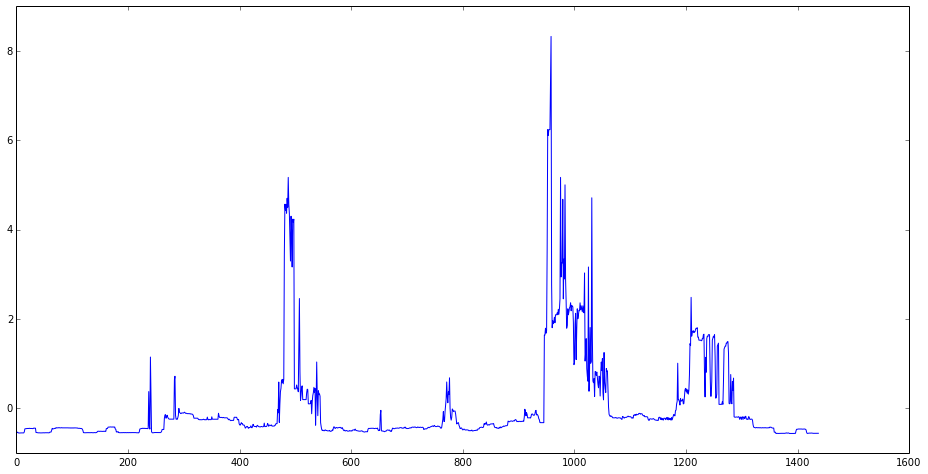

In [35]:
zts = znormalization(df_el)
plt.plot(zts)

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


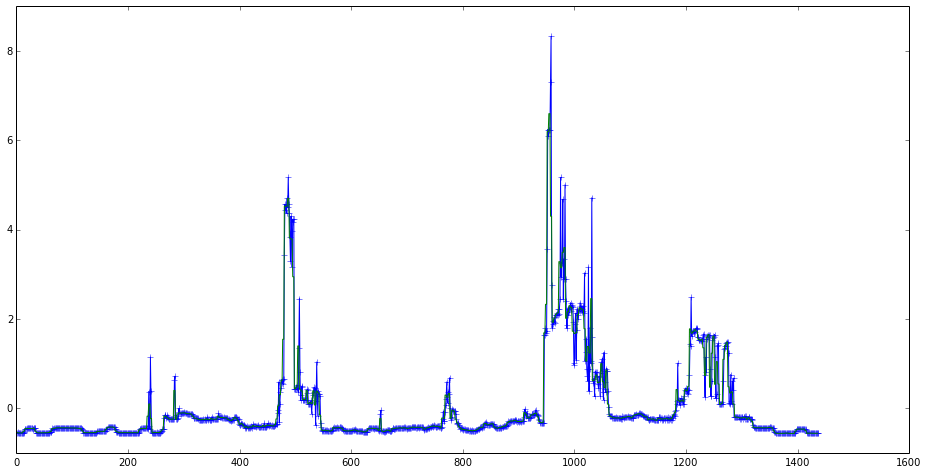

In [36]:
zScoresOriginalGraph=znormalization(df_el)
splitData = paa_transform(zScoresOriginalGraph,479)
splitData_ext = np.repeat(splitData,3,axis = 0)
pl.figure()
pl.plot(zScoresOriginalGraph, '-+')
pl.plot(splitData_ext)
pl.legend(loc = "upper left")

In [37]:
shortage = df_el.size - splitData_ext.size
if shortage > 0:
    splitData_ext = np.append(splitData_ext, [splitData_ext[-1]]*shortage)

elif shortage < 0:
    splitData_ext = splitData_ext[:abs(shortage)-1]
    
shortage = df_el.size - splitData_ext.size

In [38]:
df_paa = pd.DataFrame(index=df_el.index, data=splitData_ext)

In [39]:
result = pd.concat([zScoresOriginalGraph, df_paa], axis=1).dropna()
result.columns = ['original', 'paa']
charts.plot(result, show="inline", stock=True)

In [40]:
saxTransformation = sax_transform(df_paa, 479, "abcdefghijklmnop")

In [41]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [42]:
letters=pd.DataFrame(saxTransformation)
letters.columns=['col1']
lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array

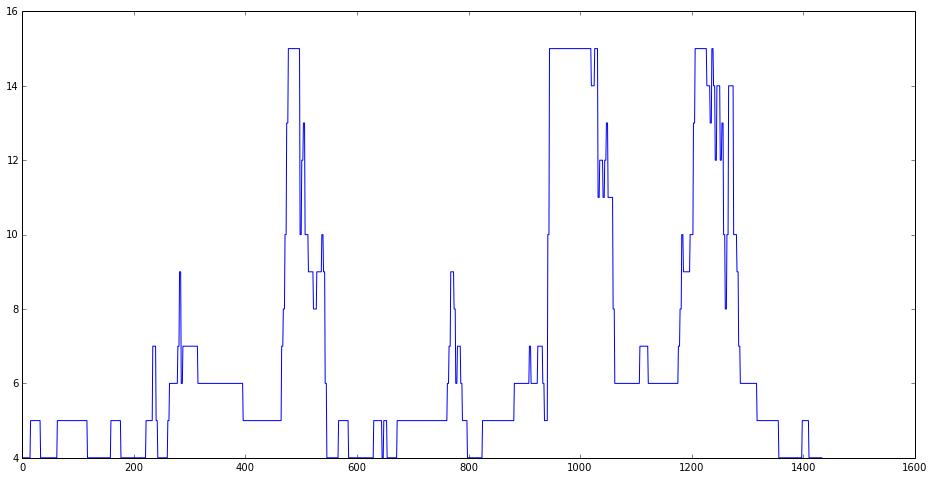

In [43]:
plt.plot(repeatedValues)

In [44]:
shortage = df_el.size - repeatedValues.size
if shortage > 0:
    repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

elif shortage < 0:
    repeatedValues = repeatedValues[:abs(shortage)-1]
    
shortage = df_el.size - repeatedValues.size

In [45]:
repeatedValues = pd.DataFrame(index=df_el.index, data=repeatedValues)
repeatedValues.columns = ['sax_value']
result = pd.concat([repeatedValues, zScoresOriginalGraph], axis=1).dropna()
result.columns = ['paa', 'original']
charts.plot(result, show="inline", stock=True)

In [46]:
#events list
events = pd.DataFrame(columns=['start', 'stop'])

searching = 'false'

lvl_on = 0
time_on = 0

for i in range(0, repeatedValues.size - 1):
    if (searching == 'false') and (repeatedValues['sax_value'].iloc[i + 1] - repeatedValues['sax_value'].iloc[i] >= 2):
        lvl_on = repeatedValues['sax_value'].iloc[i]
        time_on = str(repeatedValues.index[i])
    
        searching = 'true'
    
    elif (searching == 'true') and (repeatedValues['sax_value'].iloc[i] <= lvl_on):
        #Match
        temp = pd.DataFrame(data=[[time_on, str(repeatedValues.index[i])]], columns=['start', 'stop'])
        events = events.append(temp)
        
        searching = 'false'

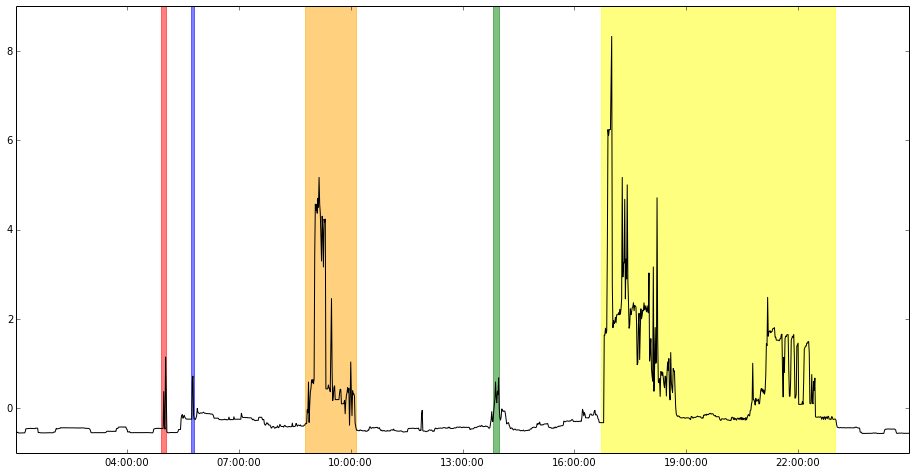

In [47]:
fig, ax = plt.subplots()
ax.plot(repeatedValues.index, zScoresOriginalGraph, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, events.index.size):
    ax.axvspan(events['start'].iloc[i], events['stop'].iloc[i], alpha=0.5, color=colors[i])

plt.show()
df_el_2 = df_el